In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


# **Data Scraping**

In [ ]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [ ]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [ ]:
df.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [ ]:
df.shape


(103, 3)

In [ ]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [ ]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [ ]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


# **Data Visualization**

In [ ]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

In [ ]:
df_toronto = df
df_toronto.head()
#how many neighbohoods in each borough
df.groupby('Borough').count()['Neighborhood']

# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))


The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [ ]:

# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

In [ ]:
CLIENT_ID = 'JMXEQSEHPVDQDHYTCGIOH3AVW5Z2IATHGIBBEROGABGTUGUH'
CLIENT_SECRET = 'AH1PKB1R2XUFX1EDVCFJQRJC1DCZ4DBFB1PEALSFOD3FYXFV'
VERSION = 20180323

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])
toronto_venues.tail()



Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2144,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,McDonald's,43.630007,-79.518041,Fast Food Restaurant
2145,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
2146,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Islington Florist & Nursery,43.630156,-79.518718,Flower Shop
2147,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2148,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


# **Data Analysis**

In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,4,4,4,4,4,4
Woodbine Heights,8,8,8,8,8,8


In [ ]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 
rest_loc = to_grouped[["Neighborhoods","Restaurant"]]
rest_loc.head()


,Neighborhoods,Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.045455
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.040000


In [ ]:
kclusters = 4

toronto_grouped_clustering = rest_loc.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
np.unique(kmeans.labels_)
to_merged = rest_loc.copy()
to_merged["Cluster Labels"] = kmeans.labels_
to_merged.head()


,Neighborhoods,Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.045455,2
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.040000,2


In [ ]:
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhoods")


In [ ]:
to_merged.head()

,Neighborhoods,Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.794200,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
1,"Alderwood, Long Branch",0.0,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [ ]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

,Neighborhoods,Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
39,"Guildwood, Morningside, West Hill",0.111111,3,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
39,"Guildwood, Morningside, West Hill",0.111111,3,43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
22,Don Mills South,0.105263,3,43.725900,-79.340923,Real Canadian Superstore,43.722704,-79.337508,Supermarket
22,Don Mills South,0.105263,3,43.725900,-79.340923,Oomomo,43.726429,-79.343283,Discount Store
22,Don Mills South,0.105263,3,43.725900,-79.340923,GoodLife Fitness North York Don Mills and Egli...,43.722704,-79.337508,Gym


In [ ]:
to_merged['Venue Category'].value_counts()['Restaurant']


65

There are 65 total restaurants in toronto. 

In [ ]:
rest_loc["Cluster Labels"] = kmeans.labels_


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


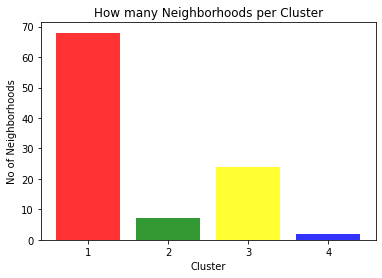

In [ ]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = rest_loc['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'green', 'yellow', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [ ]:
rest_loc['Cluster Labels'].value_counts()


0    68
2    24
1     7
3     2
Name: Cluster Labels, dtype: int64

In [ ]:
df_new = df[['Borough', 'Neighborhood']]
df_new.rename(columns={'Neighborhood': 'Neighborhoods'}, inplace=True)
df_new.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Borough,Neighborhoods
0,North York,Parkwoods
1,North York,Victoria Village
2,Downtown Toronto,"Regent Park, Harbourfront"
3,North York,"Lawrence Manor, Lawrence Heights"
4,Queen's Park,Ontario Provincial Government


In [ ]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on= 'Neighborhoods')
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhoods')
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhoods')
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhoods')

,Borough,Neighborhoods,Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Christie,0.0625,1,43.669542,-79.422564,Stubbe Chocolates,43.671566,-79.421289,Candy Store
1,Downtown Toronto,Christie,0.0625,1,43.669542,-79.422564,Actinolite,43.667858,-79.428054,Restaurant
2,Downtown Toronto,Christie,0.0625,1,43.669542,-79.422564,Faema Caffe,43.671046,-79.419297,Café
3,Downtown Toronto,Christie,0.0625,1,43.669542,-79.422564,Scout and Cash Caffe,43.667360,-79.419938,Café
4,Downtown Toronto,Christie,0.0625,1,43.669542,-79.422564,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant


Text(0.5, 1.0, 'Average number of Restaurants in each neighborhood per Cluster')

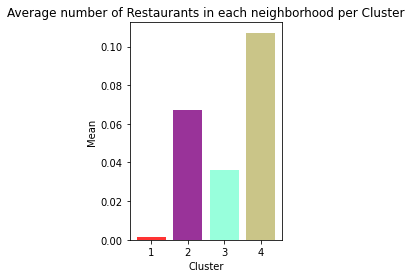

In [ ]:
plt.subplot(1, 2, 1)
clusters_mean = [df_cluster1['Restaurant'].mean(),df_cluster2['Restaurant'].mean(),df_cluster3['Restaurant'].mean(),
                df_cluster4['Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Restaurants in each neighborhood per Cluster')

# conclusion
red has the least number of average restaurants per cluster. This we cna conclude that anywhere in red would be a good place to open a restaurant. While cluster number 3 being the second best choice. We can see cluster 2 after that and cluster 4 being the worst choice. We can use similar analysis for coffee shops or clothing stores.